# Model Default

## Correlaciones

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('default_ABT2.csv')

In [4]:
df = df.fillna(0)

In [5]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2844073 entries, 0 to 2844072
Columns: 106 entries, DATE to ANTIGUEDAD_d
dtypes: float64(100), object(6)
memory usage: 2.2+ GB


In [6]:
#test droping roll_sum_60_DEFAULT
df = df.drop(['roll_sum_60_DEFAULT','roll_max_30D_DEFAULT','roll_sum_30_DEFAULT','roll_mean_30D_DEFAULT','roll_sum_7_DEFAULT','roll_max_7D_DEFAULT','roll_mean_7D_DEFAULT','lag_7_DEFAULT'], axis =1)

In [7]:
#drop default e inactive days, dejando default 'DEFAULT',
df = df.drop(['INACTIVE_DAYS'], axis =1)

In [8]:
tr = df[df['DATE']< '2023-11-01']
te = df[df['DATE']> '2023-10-31']

In [9]:
tr['DATE'].max()

'2023-10-31'

In [10]:
te['DATE'].min()

'2023-11-01'

In [11]:
tr= tr.select_dtypes(['number'])
te = te.select_dtypes(['number'])

In [12]:
#separar en train y test, nov, dic y ene
X_train = tr.drop(["TARGET"], axis=1)
y_train = tr.TARGET
X_test = te.drop(["TARGET"], axis=1)
y_test = te.TARGET

In [13]:
sttr=  StandardScaler().fit_transform(X_train)
stte=  StandardScaler().fit_transform(X_test)

In [14]:
X_train= pd.DataFrame(data = sttr, columns = X_train.columns, index = X_train.index)
X_test  = pd.DataFrame(data = stte, columns = X_test.columns, index = X_test.index)

In [15]:
# feature engineering
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler


In [16]:
features = X_train.columns
f_scores = f_classif(X_train, y_train)[0] # el [1] son los p-values.

df_fscores = pd.DataFrame({'features':features,'score':f_scores})
df_fscores = df_fscores.sort_values('score', ascending = False)
df_fscores.head(30)

,features,score
72,roll_sum_7_TX,288.477945
79,roll_sum_30_TX,261.199837
68,roll_sum_7_AMOUNT,245.078389
20,roll_mean_7D_TX,232.247438
75,roll_sum_30_AMOUNT,226.470307
0,TX,225.029285
27,roll_max_7D_TX,218.510898
49,lag_2_TX,202.565672
41,lag_1_TX,197.282225
57,lag_7_TX,197.072745


In [15]:
df_fscores.tail(10)

,features,score
43,lag_1_BALANCE,3.023984
51,lag_2_BALANCE,2.630599
95,roll_sum_60_TX_MO,2.141227
92,roll_sum_60_TOTAL_AMOUNT_MO,2.049660
2,BALANCE,1.941976
67,lag_30_BALANCE,1.587100
59,lag_7_BALANCE,1.171228
8,INACTIVE_DAYS,0.337711
19,roll_mean_7D_BALANCE,0.251412
11,roll_mean_30D_BALANCE,0.013422


In [16]:
# eliminando las features que no son relevantes
LIM_IRR = 5 # ajustable
df_fscores = df_fscores[df_fscores['score'] > LIM_IRR]
X_sel = X_train[df_fscores['features']]
X_sel.shape

(2166913, 86)

In [17]:
# seleccionando las features redundantes
xcorr = X_sel.corr().abs()
LIM_COR = 0.80 # ajustable
xcorr = xcorr[xcorr > LIM_COR].fillna(0)
index = []
column = []
for idx in list(xcorr.index):
    for col in list(xcorr.columns):
        # la matriz es diagonal
        if idx == col:
            break
        if (xcorr.loc[idx,col] != 0):
            index = index + [idx]
            column = column + [col]
df_fcorr = pd.DataFrame({'index':index, 'col':column})
df_fcorr.head(20)

,index,col
0,roll_sum_30_DEFAULT,roll_max_30D_DEFAULT
1,roll_mean_30D_DEFAULT,roll_max_30D_DEFAULT
2,roll_mean_30D_DEFAULT,roll_sum_30_DEFAULT
3,roll_max_7D_DEFAULT,roll_sum_7_DEFAULT
4,roll_mean_7D_DEFAULT,roll_sum_7_DEFAULT
5,roll_mean_7D_DEFAULT,roll_max_7D_DEFAULT
6,roll_sum_30_TX,roll_sum_7_TX
7,roll_sum_7_AMOUNT,roll_sum_7_TX
8,roll_sum_7_AMOUNT,roll_sum_30_TX
9,roll_mean_7D_TX,roll_sum_7_TX


In [18]:
X_train.dtypes

TX                      float64
AMOUNT                  float64
BALANCE                 float64
TX_check                float64
TOTAL_AMOUNT_check      float64
                         ...   
roll_sum_60_TX          float64
roll_sum_60_TX_MO       float64
roll_sum_60_TX_check    float64
roll_sum_60_DEFAULT     float64
ANTIGUEDAD_d            float64
Length: 99, dtype: object

In [19]:
y_train.dtypes

dtype('float64')

In [20]:
y_train.unique()

array([0., 1.])

# Logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_train, y_train)

0.9990161118605131

In [17]:
clf.score(X_test, y_test)

0.998899816882273

In [18]:
# guardar el modelo
from pickle import dump
with open("Logistic_reg_default.pkl", "wb") as f:
    dump(clf, f, protocol=5)

In [20]:
# Get feature importances
importances = clf.coef_[0]

# Get the feature names (assuming you have them stored in a list called 'feature_names')
feature_names = X_test.columns  # replace with your feature names

# Create DataFrame
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort DataFrame by importance
fi = fi.sort_values('importance', ascending=False)

# Print DataFrame
print(fi)

                  feature  importance
34        roll_max_30D_TX    0.140621
9    roll_mean_30D_AMOUNT    0.111602
13       roll_mean_30D_TX    0.089038
10  roll_mean_30D_BALANCE    0.082282
30    roll_max_30D_AMOUNT    0.081759
..                    ...         ...
68      roll_sum_7_AMOUNT   -0.111960
0                      TX   -0.118774
79         roll_sum_30_TX   -0.160748
72          roll_sum_7_TX   -0.170651
89           ANTIGUEDAD_d   -0.235532

[90 rows x 2 columns]


In [21]:
fi.head(30)

,feature,importance
34,roll_max_30D_TX,0.140621
9,roll_mean_30D_AMOUNT,0.111602
13,roll_mean_30D_TX,0.089038
10,roll_mean_30D_BALANCE,0.082282
30,roll_max_30D_AMOUNT,0.081759
85,roll_sum_60_TOTAL_AMOUNT_check,0.068521
17,roll_mean_7D_BALANCE,0.065748
88,roll_sum_60_TX_check,0.063281
78,roll_sum_30_TOTAL_AMOUNT_check,0.048276
8,DEFAULT,0.044899


In [22]:
fi.tail(30)

,feature,importance
37,lag_1_AMOUNT,-0.040073
21,roll_mean_7D_TX_MO,-0.041850
26,roll_max_7D_TOTAL_AMOUNT_check,-0.050319
19,roll_mean_7D_TOTAL_AMOUNT_check,-0.051103
41,lag_1_TX,-0.053552
12,roll_mean_30D_TOTAL_AMOUNT_check,-0.055447
45,lag_2_AMOUNT,-0.057816
83,roll_sum_60_BALANCE,-0.060418
11,roll_mean_30D_TOTAL_AMOUNT_MO,-0.060599
57,lag_7_TX,-0.061675


In [23]:
X_train['proba'] = clf.predict_proba(X_train)[:, 1]

In [24]:
X_test['proba'] = clf.predict_proba(X_test)[:, 1]

In [25]:
percentiles = pd.qcut(X_test['proba'], 10, labels=False, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
X_test['deciles'] = percentiles
X_test['deciles'] = X_test['deciles'].astype('Int32')


In [26]:
X_test.shape

(677160, 92)

In [27]:
y_test.shape

(677160,)

In [28]:
y_test.sum()

742.0

In [29]:
Aux = pd.merge(X_test, y_test, left_index=True,right_index=True, how='left')

In [30]:
Aux.shape

(677160, 93)

In [31]:
Aux['TARGET'].sum()

742.0

In [32]:
pd.crosstab(Aux['deciles'],Aux['TARGET'])

TARGET,0.0,1.0
deciles,,
1,67451,218
2,67585,149
3,67659,86
4,67631,85
5,67639,77
6,67664,52
7,67674,42
8,67699,17
9,67702,14


In [38]:
# obtener los valores de proba para cada decil
min_proba_per_decile = X_test.groupby('deciles')['proba'].min()

In [39]:
min_proba_per_decile

deciles
1     1.461610e-03
2     1.405204e-03
3     1.340201e-03
4     1.224094e-03
5     1.081664e-03
6     8.916501e-04
7     6.881414e-04
8     4.501019e-04
9     1.718539e-04
10    2.175496e-16
Name: proba, dtype: float64

NameError: name 'accuracy' is not defined

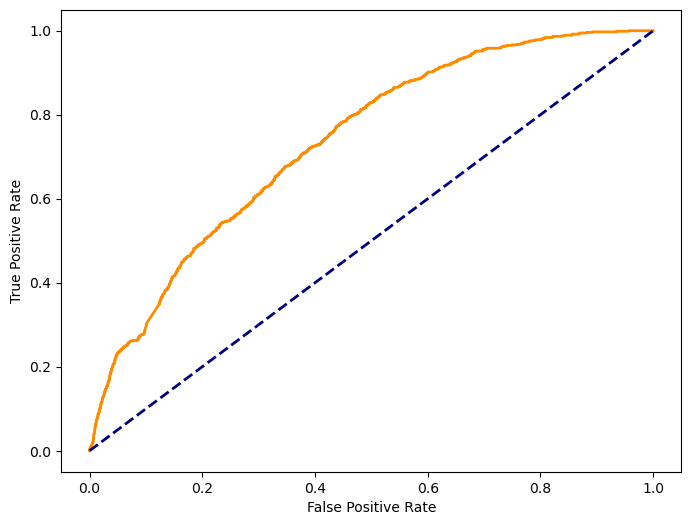

In [33]:
# Plot ROC Curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, X_test.proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy * 100))
plt.legend(loc="lower right")
plt.show()

In [ ]:
aux1 = Aux.groupby('deciles')['TARGET'].sum()

In [ ]:
aux1

# XGBOOST

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from pickle import load
with open("XGBOOST_defaul.pkl", "rb") as f:
    clf = load(f)

In [45]:
clf.score(X_test, y_test)

0.9989042471498611

In [33]:
clf.score(X_train, y_train)

0.9989958064767713

In [34]:
from sklearn.metrics import classification_report

In [46]:
print(classification_report(y_test,clf.predict(X_test)))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    676418
         1.0       0.00      0.00      0.00       742

    accuracy                           1.00    677160
   macro avg       0.50      0.50      0.50    677160
weighted avg       1.00      1.00      1.00    677160



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
# Get feature importances
importances = clf.feature_importances_

# Get the feature names (assuming you have them stored in a list called 'feature_names')
feature_names = X_test.columns  # replace with your feature names

# Create DataFrame
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort DataFrame by importance
fi = fi.sort_values('importance', ascending=False)

# Print DataFrame
print(fi)


                           feature  importance
89                    ANTIGUEDAD_d    0.999420
72                   roll_sum_7_TX    0.000169
29            roll_max_7D_TX_check    0.000098
9             roll_mean_30D_AMOUNT    0.000071
45                    lag_2_AMOUNT    0.000064
..                             ...         ...
31            roll_max_30D_BALANCE    0.000000
28               roll_max_7D_TX_MO    0.000000
27                  roll_max_7D_TX    0.000000
26  roll_max_7D_TOTAL_AMOUNT_check    0.000000
38                   lag_1_BALANCE    0.000000

[90 rows x 2 columns]


In [ ]:
fi.head(13)

In [19]:
X_test['proba'] = clf.predict_proba(X_test)[:, 1]

In [20]:
percentiles = pd.qcut(X_test['proba'], 10, labels=False, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
X_test['deciles'] = percentiles
X_test['deciles'] = X_test['deciles'].astype('Int32')


In [21]:
X_test.shape

(677160, 92)

In [22]:
y_test.shape

(677160,)

In [23]:
y_test.sum()

742.0

In [24]:
Aux = pd.merge(X_test, y_test, left_index=True,right_index=True, how='left')

In [25]:
Aux.shape

(677160, 93)

In [26]:
Aux['TARGET'].sum()

742.0

In [27]:
pd.crosstab(Aux['deciles'],Aux['TARGET'])

TARGET,0.0,1.0
deciles,,
1,67472,228
2,63347,81
3,36700,61
4,102866,100
5,67602,40
6,65981,80
7,66548,41
8,70317,86
9,67829,19


In [28]:
# obtener los valores de proba para cada decil
min_proba_per_decile = X_test.groupby('deciles')['proba'].min()

In [37]:
min_proba_per_decile

deciles
1     0.002203
2     0.001440
3     0.000981
4     0.000611
5     0.000463
6     0.000242
7     0.000144
8     0.000115
9     0.000064
10    0.000005
Name: proba, dtype: float64

NameError: name 'accuracy' is not defined

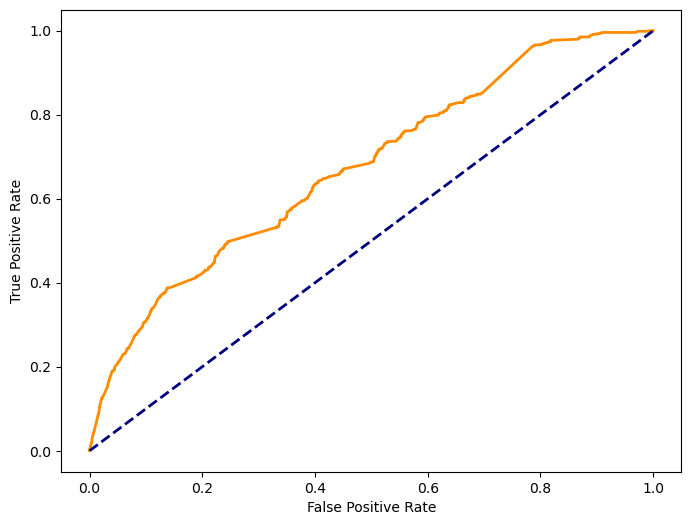

In [29]:
# Plot ROC Curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, X_test.proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy * 100))
plt.legend(loc="lower right")
plt.show()

In [18]:
# guardar el modelo
from pickle import dump
with open("XGBOOST_defaul.pkl", "wb") as f:
    dump(clf, f, protocol=5)

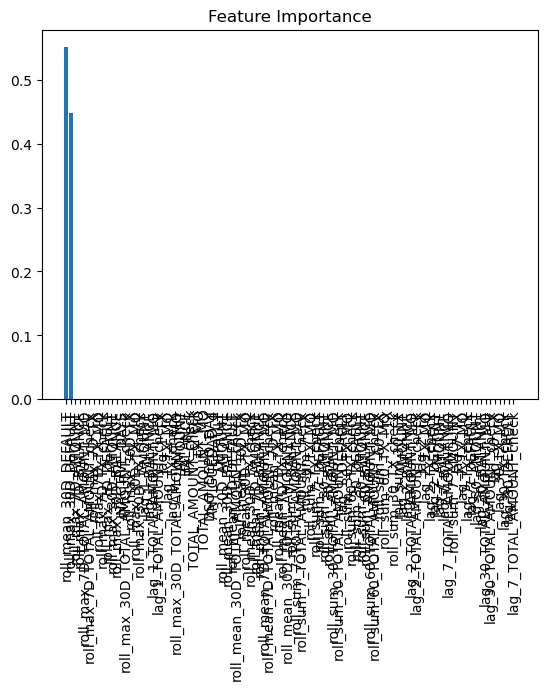

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = clf.feature_importances_

# Get the feature names (assuming you have them stored in a list called 'feature_names')
feature_names = X_test.columns  # replace with your feature names

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(len(importances)), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(len(importances)), names, rotation=90)

# Show plot
plt.show()


In [27]:
X_train.shape

(2166913, 98)

In [28]:
X_test.shape

(677160, 98)

In [16]:
X_train.head(10)

,TX,AMOUNT,BALANCE,TX_check,TOTAL_AMOUNT_check,TX_MO,TOTAL_AMOUNT_MO,DSO_DEPO_DAY,INACTIVE_DAYS,DEFAULT,...,roll_sum_30_DEFAULT,roll_sum_60_AMOUNT,roll_sum_60_BALANCE,roll_sum_60_TOTAL_AMOUNT_MO,roll_sum_60_TOTAL_AMOUNT_check,roll_sum_60_TX,roll_sum_60_TX_MO,roll_sum_60_TX_check,roll_sum_60_DEFAULT,ANTIGUEDAD_d
0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1552.0
1,0.0,0.0,13853.8257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1553.0
2,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1554.0
3,1.0,340.0,13853.8257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1555.0
4,1.0,25.0,14202.1057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1556.0
5,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1557.0
6,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1558.0
7,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1559.0
8,6.0,6.0,14232.1057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1560.0
9,1.0,1.0,14268.1057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1561.0


In [17]:
df.head(10)

,DATE,ID_BRANCH,TX,AMOUNT,BALANCE,TX_check,TOTAL_AMOUNT_check,TX_MO,TOTAL_AMOUNT_MO,DSO_DEPO_DAY,...,roll_sum_30_DEFAULT,roll_sum_60_AMOUNT,roll_sum_60_BALANCE,roll_sum_60_TOTAL_AMOUNT_MO,roll_sum_60_TOTAL_AMOUNT_check,roll_sum_60_TX,roll_sum_60_TX_MO,roll_sum_60_TX_check,roll_sum_60_DEFAULT,ANTIGUEDAD_d
0,2023-01-01,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1552.0
1,2023-01-02,A00002,0.0,0.0,13853.8257,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1553.0
2,2023-01-03,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1554.0
3,2023-01-04,A00002,1.0,340.0,13853.8257,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1555.0
4,2023-01-05,A00002,1.0,25.0,14202.1057,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1556.0
5,2023-01-06,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1557.0
6,2023-01-07,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1558.0
7,2023-01-08,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1559.0
8,2023-01-09,A00002,6.0,6.0,14232.1057,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1560.0
9,2023-01-10,A00002,1.0,1.0,14268.1057,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1561.0


In [29]:
X_train['roll_max_30D_DEFAULT'].unique()

array([0., 1.])

In [30]:
X_train['roll_max_30D_DEFAULT'].unique()

array([0., 1.])

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


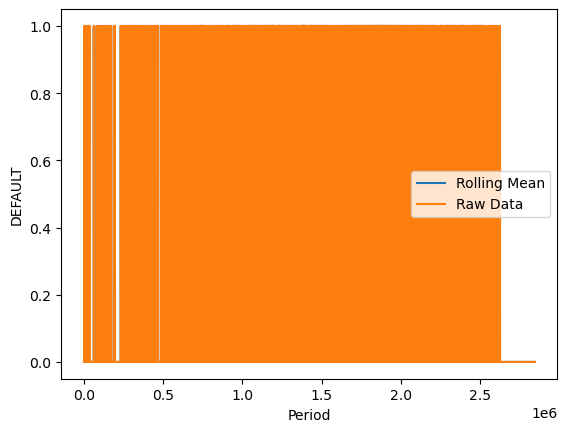

In [33]:
import matplotlib.pyplot as plt
plt.plot(X_train['roll_max_30D_DEFAULT'], label='Rolling Mean')
plt.plot(y_train, label='Raw Data')
plt.legend()
plt.ylabel('DEFAULT')
plt.xlabel('Period')
plt.show()

In [63]:
y_train.sum()

2131.0

In [64]:
y_test.sum()

742.0

In [65]:
y_train.shape

(2166913,)

In [66]:
2131/2166913*100

0.09834266534927798

In [ ]:
el 0.098% es target, modelo que sólo predice 0 tiene 99.912% de aciertos

# Dimensionar casos de default de 1 semana

In [5]:
# lunes 4 de septiembre a domingo 10
tr = df[df['DATE']< '2023-09-11']
te = tr[tr['DATE']> '2023-09-03']

In [50]:
te['DEFAULT'].sum()

33.0

In [51]:
te['TARGET'].sum()

58.0

In [9]:
te.shape

(49896, 106)

In [10]:
# % de default
33/49896*100

0.06613756613756613

In [11]:
# % de target
58/49896*100

0.11624178290844957

In [7]:
lu = te[te['DATE']== '2023-09-04']

In [8]:
print (lu['DEFAULT'].sum()/len(lu)*100)
print (lu['TARGET'].sum()/len(lu)*100)

0.05611672278338946
0.2665544332210999


In [9]:
ma = te[te['DATE']== '2023-09-05']
print (ma['DEFAULT'].sum()/len(ma)*100)
print (ma['TARGET'].sum()/len(ma)*100)

0.16835016835016833
0.12626262626262627


In [10]:
mi = te[te['DATE']== '2023-09-06']
print (mi['DEFAULT'].sum()/len(mi)*100)
print (mi['TARGET'].sum()/len(mi)*100)

0.09820426487093155
0.11223344556677892


In [11]:
ju = te[te['DATE']== '2023-09-07']
print (ju['DEFAULT'].sum()/len(ju)*100)
print (ju['TARGET'].sum()/len(ju)*100)

0.014029180695847365
0.014029180695847365


In [12]:
vi = te[te['DATE']== '2023-09-08']
print (vi['DEFAULT'].sum()/len(vi)*100)
print (vi['TARGET'].sum()/len(vi)*100)

0.08417508417508417
0.0


In [13]:
sa = te[te['DATE']== '2023-09-09']
print (sa['DEFAULT'].sum()/len(sa)*100)
print (sa['TARGET'].sum()/len(sa)*100)

0.04208754208754208
0.23849607182940516


In [14]:
do = te[te['DATE']== '2023-09-10']
print (do['DEFAULT'].sum()/len(do)*100)
print (do['TARGET'].sum()/len(do)*100)

0.0
0.05611672278338946


In [60]:
print (lu['DEFAULT'].sum()/len(lu)*100)
print (ma['DEFAULT'].sum()/len(ma)*100)
print (mi['DEFAULT'].sum()/len(mi)*100)
print (ju['DEFAULT'].sum()/len(ju)*100)
print (vi['DEFAULT'].sum()/len(vi)*100)
print (sa['DEFAULT'].sum()/len(sa)*100)
print (do['DEFAULT'].sum()/len(do)*100)

0.05611672278338946
0.16835016835016833
0.09820426487093155
0.014029180695847365
0.08417508417508417
0.04208754208754208
0.0


In [61]:
print (lu['TARGET'].sum()/len(lu)*100)
print (ma['TARGET'].sum()/len(ma)*100)
print (mi['TARGET'].sum()/len(mi)*100)
print (ju['TARGET'].sum()/len(ju)*100)
print (vi['TARGET'].sum()/len(vi)*100)
print (sa['TARGET'].sum()/len(sa)*100)
print (do['TARGET'].sum()/len(do)*100)

0.2665544332210999
0.12626262626262627
0.11223344556677892
0.014029180695847365
0.0
0.23849607182940516
0.05611672278338946


In [62]:
print (len(lu))
print (len(ma))
print (len(mi))
print (len(ju))
print (len(vi))
print (len(sa))
print (len(do))

7128
7128
7128
7128
7128
7128
7128


In [64]:
print (lu['TARGET'].sum())
print (ma['TARGET'].sum())
print (mi['TARGET'].sum())
print (ju['TARGET'].sum())
print (vi['TARGET'].sum())
print (sa['TARGET'].sum())
print (do['TARGET'].sum())

19.0
9.0
8.0
1.0
0.0
17.0
4.0


In [15]:
print (lu['DEFAULT'].sum())
print (ma['DEFAULT'].sum())
print (mi['DEFAULT'].sum())
print (ju['DEFAULT'].sum())
print (vi['DEFAULT'].sum())
print (sa['DEFAULT'].sum())
print (do['DEFAULT'].sum())

4.0
12.0
7.0
1.0
6.0
3.0
0.0


# Propbando historial de ventiles en el que caen las agencias en días corridos

In [8]:
df = pd.read_csv('default_prediction_test.csv') #, encoding='latin-1', sep=';'
df['UNI']=1
df.head()
#df.describe()


,DATE,ID_BRANCH,AGENCY,ID_GROUP_COMPANY,BALANCE,DEFAULT,TARGET,proba,UNI
0,2023-11-01,A00002,MD0002,USA000002,17816.1267,0.0,0.0,0.000913,1
1,2023-11-02,A00002,MD0002,USA000002,17924.2267,0.0,0.0,0.000914,1
2,2023-11-03,A00002,MD0002,USA000002,18006.2267,0.0,0.0,0.000932,1
3,2023-11-04,A00002,MD0002,USA000002,0.0000,0.0,0.0,0.000894,1
4,2023-11-05,A00002,MD0002,USA000002,0.0000,0.0,0.0,0.000893,1


In [9]:
#deciles de la variable MonthlyCharges
dec_rfm=df['proba'].quantile([0.05,.1,0.15,.2,0.25,.3,0.35,.4,0.45,.5,0.55,.6,0.65,.7,0.75,.8,0.85,.9,0.95]).tolist()

dec_rfm

[1.5628753160475284e-05,
 8.60008313116491e-05,
 0.000192875279525655,
 0.00031243840476858,
 0.00042315877378955,
 0.00051674928139408,
 0.0006002218899612401,
 0.0006760368658799,
 0.00075183445462384,
 0.00081247178694465,
 0.0008614892104977,
 0.00090414935220706,
 0.0009359294245784251,
 0.0009572632471892,
 0.00097624391538795,
 0.0009988844359333,
 0.0010052816573873,
 0.0010406720221193399,
 0.001525513546907148]

In [10]:
#reagrupo la variable TotalCharges en base al decil
conditions2 = [
    (df['proba'] <= dec_rfm[0]),
    (df['proba'] <= dec_rfm[1]),
    (df['proba'] <= dec_rfm[2]),
    (df['proba'] <= dec_rfm[3]),
    (df['proba']<= dec_rfm[4]),
    (df['proba']<= dec_rfm[5]),
    (df['proba']<= dec_rfm[6]),
    (df['proba']<= dec_rfm[7]),
    (df['proba']<= dec_rfm[8]),
    (df['proba']<= dec_rfm[9]),
    (df['proba']<= dec_rfm[10]),
    (df['proba']<= dec_rfm[11]),
    (df['proba']<= dec_rfm[12]),
    (df['proba']<= dec_rfm[13]),
    (df['proba']<= dec_rfm[14]),
    (df['proba']<= dec_rfm[15]),
    (df['proba']<= dec_rfm[16]),
    (df['proba']<= dec_rfm[17]),
    (df['proba']<= dec_rfm[18])]
choices2 = [0,1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
df['proba_c'] = np.select(conditions2, choices2, default=19)

In [11]:
DIA = df.groupby(['proba_c']).count().reset_index()
print(DIA)


    proba_c   DATE  ID_BRANCH  AGENCY  ID_GROUP_COMPANY  BALANCE  DEFAULT  \
0         0  33858      33858   33858             33858    33858    33858   
1         1  33858      33858   33858             33858    33858    33858   
2         2  33858      33858   33858             33858    33858    33858   
3         3  33858      33858   33858             33858    33858    33858   
4         4  33858      33858   33858             33858    33858    33858   
5         5  33858      33858   33858             33858    33858    33858   
6         6  33858      33858   33858             33858    33858    33858   
7         7  33858      33858   33858             33858    33858    33858   
8         8  33858      33858   33858             33858    33858    33858   
9         9  33858      33858   33858             33858    33858    33858   
10       10  33872      33872   33872             33872    33872    33872   
11       11  33844      33844   33844             33844    33844    33844   

In [12]:
#cantidad en cada percentil
aux=pd.pivot_table(df,index=['DATE','proba_c','AGENCY'],aggfunc='sum',values=['TARGET','BALANCE','UNI'])
print(aux)

#aux.to_csv('/content/drive/MyDrive/bases/date_per2.csv')

#DIA = df.groupby(['DATE','proba_c']).count().reset_index()

#cantidad en cada percentil
aux2=pd.pivot_table(df,index=['AGENCY'],columns='DATE',aggfunc='mean',values=['proba_c'])
print(aux2)

#aux2.to_csv('/content/drive/MyDrive/bases/date_agency.csv')

                               BALANCE  TARGET  UNI
DATE       proba_c AGENCY                          
2023-11-01 0       AL0281   23783.2500     0.0    1
                   AL0283   28992.9607     0.0    1
                   AL0310   38800.3432     0.0    1
                   AL0313   72260.0664     0.0    1
                   AL0325  218658.8963     0.0    1
...                                ...     ...  ...
2024-02-03 19      WI0146       0.0000     0.0    1
                   WI0219       0.0000     0.0    1
                   WI0242       0.0000     0.0    1
                   WI0243       0.0000     0.0    1
                   WI0259     420.0000     0.0    1

[655660 rows x 3 columns]
          proba_c                                                         \
DATE   2023-11-01 2023-11-02 2023-11-03 2023-11-04 2023-11-05 2023-11-06   
AGENCY                                                                     
0       15.664921  15.685864  15.581152  15.633508  15.586387  15.612

In [13]:
aux2.to_csv('date_agency.csv')

In [14]:
aux3=pd.pivot_table(df,index=['ID_BRANCH'],columns='DATE',aggfunc='mean',values=['proba_c'])
print(aux3)

             proba_c                                                         \
DATE      2023-11-01 2023-11-02 2023-11-03 2023-11-04 2023-11-05 2023-11-06   
ID_BRANCH                                                                     
A00002          12.0       12.0       12.0       11.0       11.0       12.0   
A00138           6.0        6.0        6.0        6.0        6.0        6.0   
A00147           6.0        6.0        5.0        5.0        6.0        6.0   
A00148           7.0        7.0        7.0        7.0        7.0        7.0   
A00149           6.0        6.0        6.0        6.0        6.0        6.0   
...              ...        ...        ...        ...        ...        ...   
A99947          18.0       18.0       16.0       18.0       18.0       18.0   
A99982          17.0       17.0       17.0       17.0       15.0       15.0   
AB0106           1.0        2.0        1.0        1.0        1.0        1.0   
AB0110           3.0        3.0        3.0        4.

In [16]:
aux3.to_csv('date_id_branch.csv')

# Seguimiento de 3 agencias interesantes

In [ ]:
A04201 A01512(inactiva sólo un past due fantasma) A00806 A02061

In [38]:
df = pd.read_csv('default_ABT1.csv')

In [39]:
df = df.fillna(0)

In [40]:
te = df[df['DATE']> '2023-10-31']

In [41]:
te.head()

,DATE,ID_BRANCH,TX,AMOUNT,BALANCE,TX_check,TOTAL_AMOUNT_check,TX_MO,TOTAL_AMOUNT_MO,DSO_DEPO_DAY,INACTIVE_DAYS,DEFAULT,AGENCY,ID_GROUP_COMPANY,START_DATE,day_of_week,TARGET
304,2023-11-01,A00002,1.0,10.0,17816.1267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MD0002,USA000002,2018-10-02,Wednesday,0.0
305,2023-11-02,A00002,7.0,40.0,17924.2267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MD0002,USA000002,2018-10-02,Thursday,0.0
306,2023-11-03,A00002,3.0,22.0,18006.2267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MD0002,USA000002,2018-10-02,Friday,0.0
307,2023-11-04,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MD0002,USA000002,2018-10-02,Saturday,0.0
308,2023-11-05,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MD0002,USA000002,2018-10-02,Sunday,0.0


In [42]:
A04201 = te[te['ID_BRANCH']== 'A04201']

In [43]:
A04201

,DATE,ID_BRANCH,TX,AMOUNT,BALANCE,TX_check,TOTAL_AMOUNT_check,TX_MO,TOTAL_AMOUNT_MO,DSO_DEPO_DAY,INACTIVE_DAYS,DEFAULT,AGENCY,ID_GROUP_COMPANY,START_DATE,day_of_week,TARGET
64144,2023-11-01,A04201,7.0,1325.00,-338.2819,0.0,0.00,0.0,0.0,0.0,0.0,0.0,VA0348,USA000768,2009-04-04,Wednesday,0.0
64145,2023-11-02,A04201,96.0,57845.00,-5762.8319,0.0,0.00,0.0,0.0,0.0,0.0,0.0,VA0348,USA000768,2009-04-04,Thursday,0.0
64146,2023-11-03,A04201,2.0,690.00,52928.6481,21.0,29312.19,0.0,0.0,0.0,0.0,0.0,VA0348,USA000768,2009-04-04,Friday,0.0
64147,2023-11-04,A04201,2.0,740.00,707.4581,0.0,0.00,0.0,0.0,0.0,0.0,0.0,VA0348,USA000768,2009-04-04,Saturday,0.0
64148,2023-11-05,A04201,123.0,61375.00,1463.4581,0.0,0.00,0.0,0.0,0.0,0.0,0.0,VA0348,USA000768,2009-04-04,Sunday,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,2024-01-30,A04201,33.0,12968.00,3751.2011,0.0,0.00,0.0,0.0,0.0,0.0,0.0,VA0348,USA000768,2009-04-04,Tuesday,0.0
64235,2024-01-31,A04201,0.0,0.00,0.0000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,VA0348,USA000768,2009-04-04,Wednesday,0.0
64236,2024-02-01,A04201,102.0,47286.73,0.2011,0.0,0.00,0.0,0.0,0.0,0.0,0.0,VA0348,USA000768,2009-04-04,Thursday,0.0
64237,2024-02-02,A04201,1.0,500.00,44507.7284,8.0,12225.76,0.0,0.0,0.0,0.0,0.0,VA0348,USA000768,2009-04-04,Friday,0.0


In [44]:
A04201.to_csv('A04201.csv')

In [45]:
A01512 = te[te['ID_BRANCH']== 'A01512']
A01512.shape

(95, 17)

In [46]:
A01512.to_csv('A01512.csv')

In [49]:
A02061 = te[te['ID_BRANCH']== 'A02061']
A02061.shape

(95, 17)

In [51]:
A02061.to_csv('A02061.csv')

# idem pero sumando variables pesadas para diagnostico

In [4]:
df = pd.read_csv('default_ABT2.csv')

In [5]:
df = df.fillna(0)

In [6]:
lista = ['DATE','ID_BRANCH','TX','BALANCE','TX_check','TOTAL_AMOUNT_check','DSO_DEPO_DAY','roll_max_30D_TX','roll_mean_30D_AMOUNT','roll_mean_30D_TX','roll_sum_30_TX','roll_sum_7_TX','ANTIGUEDAD_d']
df = df[lista]

In [7]:
te = df[df['DATE']> '2023-10-31']

In [7]:
te.head()

,DATE,ID_BRANCH,TX,BALANCE,TX_check,TOTAL_AMOUNT_check,DSO_DEPO_DAY,roll_max_30D_TX,roll_mean_30D_AMOUNT,roll_mean_30D_TX,roll_sum_30_TX,roll_sum_7_TX,ANTIGUEDAD_d
304,2023-11-01,A00002,1.0,17816.1267,0.0,0.0,0.0,8.0,14.26,1.90,0.0,0.0,1856.0
305,2023-11-02,A00002,7.0,17924.2267,0.0,0.0,0.0,8.0,15.63,2.10,0.0,0.0,1857.0
306,2023-11-03,A00002,3.0,18006.2267,0.0,0.0,0.0,8.0,16.62,2.19,0.0,0.0,1858.0
307,2023-11-04,A00002,0.0,0.0000,0.0,0.0,0.0,8.0,15.90,2.10,0.0,0.0,1859.0
308,2023-11-05,A00002,0.0,0.0000,0.0,0.0,0.0,8.0,15.95,2.05,0.0,0.0,1860.0


In [8]:
A04201 = te[te['ID_BRANCH']== 'A04201']

In [9]:
A04201

,DATE,ID_BRANCH,TX,BALANCE,TX_check,TOTAL_AMOUNT_check,DSO_DEPO_DAY,roll_max_30D_TX,roll_mean_30D_AMOUNT,roll_mean_30D_TX,roll_sum_30_TX,roll_sum_7_TX,ANTIGUEDAD_d
64144,2023-11-01,A04201,7.0,-338.2819,0.0,0.00,0.0,296.0,29563.05,65.24,0.0,0.0,5324.0
64145,2023-11-02,A04201,96.0,-5762.8319,0.0,0.00,0.0,296.0,28432.77,63.48,0.0,0.0,5325.0
64146,2023-11-03,A04201,2.0,52928.6481,21.0,29312.19,0.0,296.0,28420.17,63.48,0.0,0.0,5326.0
64147,2023-11-04,A04201,2.0,707.4581,0.0,0.00,0.0,296.0,26521.24,60.20,0.0,0.0,5327.0
64148,2023-11-05,A04201,123.0,1463.4581,0.0,0.00,0.0,296.0,27861.77,62.62,0.0,0.0,5328.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,2024-01-30,A04201,33.0,3751.2011,0.0,0.00,0.0,145.0,18794.99,35.14,0.0,0.0,5414.0
64235,2024-01-31,A04201,0.0,0.0000,0.0,0.00,0.0,145.0,18794.99,35.14,0.0,0.0,5415.0
64236,2024-02-01,A04201,102.0,0.2011,0.0,0.00,0.0,120.0,17206.16,33.18,0.0,0.0,5416.0
64237,2024-02-02,A04201,1.0,44507.7284,8.0,12225.76,0.0,120.0,16479.81,31.78,0.0,0.0,5417.0


In [10]:
A04201.to_csv('A04201_extra.csv', index=False)

In [15]:
A00806 = te[te['ID_BRANCH']== 'A00806']
A00806.shape

(95, 13)

In [16]:
A00806.to_csv('A00806_extra.csv', index=False)

In [13]:
A02061 = te[te['ID_BRANCH']== 'A02061']
A02061.shape

(95, 13)

In [14]:
A02061.to_csv('A02061_extra.csv', index=False)

## sumando un par más de agencias A05935 y A25765

In [8]:
A05935 = te[te['ID_BRANCH']== 'A05935']
A05935.shape

(95, 13)

In [9]:
A05935.to_csv('A05935_extra.csv', index=False)

In [10]:
A25765 = te[te['ID_BRANCH']== 'A25765']
A25765.shape

(95, 13)

In [11]:
A25765.to_csv('A25765_extra.csv', index=False)

# está roto MO?

In [14]:
mo = pd.read_csv('MO.csv')

In [15]:
mo.head()

,DATE,unique_senders,TX,TX_CANCELLED,TOTAL_AMOUNT,GP,state,id_chain,name_chain,id_location,name_location,id_branch,name_branch,kpr,LATITUD,LONGITUD,ZIP,id_agent,TYPE_PRODUCT
0,2023-01-01,0,19,0,12057.27,7.41,MD,USA010063,CONTINENTAL EXPRESS LLC.,MD0881,CONTINENTAL EXPRESS (SILVER SPRING),A18151,CONTINENTAL EXPRESS (SILVER SPRING),KPR3,38.997934,-77.002871,20901,279,MONEY ORDERS
1,2023-01-01,0,2,0,735.00,0.78,IA,USA018548,LA TAPATIA (DES MOINES),IA0049,LA TAPATIA (DES MOINES),A22027,LA TAPATIA (DES MOINES),KPR3,41.595685,-93.596378,50316,305,MONEY ORDERS
2,2023-01-01,0,63,0,45857.82,24.57,CA,USA017524,SALSA MARKET (CA),CA3817,SALSA MARKET (CA),A20556,SALSA MARKET (CA),KPR3,33.214296,-117.245221,92083,270,MONEY ORDERS
3,2023-01-01,0,1,0,950.00,0.39,TX,USA019060,ENVIOS EXPRESS (GARLAND),TX1252,ENVIOS EXPRESS (GARLAND),A22788,ENVIOS EXPRESS (GARLAND),KPR3,32.879092,-96.631672,75041,374,MONEY ORDERS
4,2023-01-01,0,1,0,625.00,0.39,MD,USA014807,MERCADO LATINO 2,MD0803,HERNANDEZ GROCERY STORE,A17199,HERNANDEZ GROCERY STORE (PC),KPR3,38.774011,-76.070824,21601,279,MONEY ORDERS


In [16]:
A04201mo = mo[mo['id_branch']== 'A04201']

In [17]:
A04201mo

,DATE,unique_senders,TX,TX_CANCELLED,TOTAL_AMOUNT,GP,state,id_chain,name_chain,id_location,name_location,id_branch,name_branch,kpr,LATITUD,LONGITUD,ZIP,id_agent,TYPE_PRODUCT


In [18]:
A01512mo = mo[mo['id_branch']== 'A01512']

In [19]:
A01512mo

,DATE,unique_senders,TX,TX_CANCELLED,TOTAL_AMOUNT,GP,state,id_chain,name_chain,id_location,name_location,id_branch,name_branch,kpr,LATITUD,LONGITUD,ZIP,id_agent,TYPE_PRODUCT


In [20]:
A00806mo = mo[mo['id_branch']== 'A00806']

In [21]:
A00806mo

,DATE,unique_senders,TX,TX_CANCELLED,TOTAL_AMOUNT,GP,state,id_chain,name_chain,id_location,name_location,id_branch,name_branch,kpr,LATITUD,LONGITUD,ZIP,id_agent,TYPE_PRODUCT


## querry actualizada es diferente?

In [22]:
pip install awswrangler

  Using cached awswrangler-3.9.1-py3-none-any.whl.metadata (17 kB)
Using cached awswrangler-3.9.1-py3-none-any.whl (381 kB)
Note: you may need to restart the kernel to use updated packages.


In [23]:
import sys
!{sys.executable} -m pip install PyAthena

  Using cached pyathena-3.9.0-py3-none-any.whl.metadata (6.3 kB)
Using cached pyathena-3.9.0-py3-none-any.whl (75 kB)


In [24]:
from pyathena import connect

In [25]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'

#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')

mo = pd.read_sql('''SELECT
   CAST(DATE_FORMAT(a.TRANSACTION_DATE, '%Y-%m-%d') AS DATE) AS DATE,
   COUNT(DISTINCT a.ID_MONEYORDERS_SALES) AS TX_MO,
   SUM(a.AMOUNT) AS TOTAL_AMOUNT_MO,
   r.id_branch as ID_BRANCH
FROM
   AwsDataCatalog.viamericas.vcw_moneyorders_sales a
   LEFT JOIN AwsDataCatalog.viamericas.branch b ON b.ID_BRANCH = a.id_branch
   LEFT JOIN AwsDataCatalog.viamericas.branch_agent f ON f.id_branch =b.id_branch
   LEFT JOIN AwsDataCatalog.viamericas.chain g ON g.id_chain =b.id_chain
   LEFT JOIN AwsDataCatalog.viamericas.BUDGET_LOCATIONS_INCLUDED h ON h.id_location =b.id_location
   LEFT JOIN AwsDataCatalog.analytics.location_branch_reference r ON r.id_branch = b.id_branch
WHERE
   NOT (b.ID_MAIN_BRANCH LIKE 'M%')
   AND NOT (a.id_branch LIKE 'T%')
   AND b.id_flag_branch = 'A'
   AND DATE_FORMAT(TRANSACTION_DATE, '%Y-%m') > '2022-12' AND DATE_FORMAT(TRANSACTION_DATE, '%Y-%m') < '2024-02' 
   AND  NOT r.id_location = 'NULL'
   AND b.name_branch not like '%DUMMY%'
 GROUP BY
   CAST(DATE_FORMAT(a.TRANSACTION_DATE, '%Y-%m-%d') AS DATE),
   r.id_branch
  ORDER BY 
   DATE;''', conn)

/tmp/ipykernel_22/3330182756.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mo = pd.read_sql('''SELECT


In [34]:
mo.tail()

,DATE,TX_MO,TOTAL_AMOUNT_MO,ID_BRANCH
138573,2024-01-31,2,1600.00,A24329
138574,2024-01-31,13,9487.45,A19003
138575,2024-01-31,14,5555.00,A19343
138576,2024-01-31,6,2755.00,A17101
138577,2024-01-31,4,2801.00,A22616


In [28]:
A04201mo = mo[mo['ID_BRANCH']== 'A04201']

In [29]:
A04201mo

,DATE,TX_MO,TOTAL_AMOUNT_MO,ID_BRANCH


In [30]:
A01512mo = mo[mo['ID_BRANCH']== 'A01512']

In [33]:
A01512mo

,DATE,TX_MO,TOTAL_AMOUNT_MO,ID_BRANCH


In [31]:
A00806mo = mo[mo['ID_BRANCH']== 'A00806']

In [32]:
A00806mo

,DATE,TX_MO,TOTAL_AMOUNT_MO,ID_BRANCH


In [35]:
df['TX_MO'].unique()

array([ nan,  12.,  11.,   9.,   4.,   5.,   2.,   1.,   6.,   3.,   8.,
        10.,  15.,  19.,  14.,   7.,  13.,  16.,  17.,  20.,  18.,  96.,
       148., 131., 112.,  24.,  31.,  26.,  21.,  23.,  28.,  32.,  64.,
        72.,  61., 113., 125.,  95.,  41.,  29.,  25.,  30.,  52.,  55.,
        75.,  58., 106., 129.,  90.,  45.,  44.,  80., 116., 108.,  22.,
        27.,  37.,  86.,  81.,  82., 139.,  48.,  34.,  92.,  98.,  35.,
        54.,  79.,  65.,  59., 126.,  36.,  97., 163., 130.,  38.,  42.,
        63., 111., 187.,  33.,  77., 149., 110., 103.,  49., 135., 120.,
        91., 158., 132., 124., 136., 145., 114., 133., 100.,  51.,  83.,
       319.,  94.,  46.,  87.,  68.,  53.,  57.,  69., 119.,  62.,  66.,
       107.,  84.,  76.,  43., 137.,  40.,  74.,  85.,  56.,  89.,  47.,
       128., 122.,  78., 165., 153., 134., 118., 117., 157., 138., 121.,
       164., 154.,  88.,  93.,  71.,  99., 101., 102.,  60.,  73., 105.,
        50., 144., 142., 123., 115., 167., 169., 14

In [36]:
df['TOTAL_AMOUNT_MO'].unique()

array([    nan, 6746.61, 4830.27, ..., 9697.85, 4903.88, 1127.06])